<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li></ul></div>

# Introduction

In [1]:
import sys
print(sys.prefix)

/Users/phil/a50037/envs/a500


In [2]:
import sys
import a500

#!conda install --yes --prefix {sys.prefix} netcdf4

Solving environment: done

# All requested packages already installed.



In [3]:
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import numpy as np


# # The Dry LES dataset
# 
# This notebook looks at a portion of a dataset that was generated by running a large eddy simulation 10 different times with identical conditions.  The 10 realizations of temperature and pressure are stored as a single netcdf file

# # Intro to netcdf
# 
# See the function descriptions and tutorial at http://unidata.github.io/netcdf4-python/

# # Intro to python packages
# 
# a. do the following to install the course python code using [pip][1]:
#    
#      cd atsc405
#      git fetch origin
#      git reset --hard origin/master
#      pip install -e .
#     
#    (this is called an "editable install", for reasons I'll explain in class)
#    
#    [1]: https://en.wikipedia.org/wiki/Pip_(package_manager)
#  
# b. Check the install by executing the cell below:
# 
#    If it succeeds, you should see:
#    
#        download case_60_10.nc: size is    499.3 Mbytes

In [4]:
from  a500.utils.data_read import download
the_root="http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/"
the_file='case_60_10.nc'
out=download(the_file,root=the_root)


# # Dumping the netcdf metadata

# Netcdf file layout:  10 groups corresponding to 10 different ensemble members.  Small slice of larger domain of LES run with surface heat flux of 60 W/m^2 and stable layer with dT/dz = 10 K/km.  Snapshots every 10 minutes for 8 hours.
# 
# We can read the metdata using 

trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/data//case_60_10.nc
writing to: case_60_10.nc

case_60_10.nc already exists
and is 499251027 bytes
will not overwrite



In [5]:
from a500.utils.ncdump import ncdump


with Dataset(the_file) as nc_in:
    ncdump(nc_in)

NetCDF Global Attributes:
	heat_flux_W_m2: 100
	gamma_K_km: 10
NetCDF dimension information:
	Name: time
		size: 48
		type: dtype('float32')
		units: 'minutes'
	Name: x
		size: 25
		type: dtype('float32')
		units: 'meters'
	Name: y
		size: 20
		type: dtype('float32')
		units: 'meters'
	Name: z
		size: 130
		type: dtype('float32')
		units: 'meters'
NetCDF variable information for group c1:
	Name: TABS
		dimensions: ('time', 'z', 'y', 'x')
		size: 3120000
	Name: W
		dimensions: ('time', 'z', 'y', 'x')
		size: 3120000
	Name: U
		dimensions: ('time', 'z', 'y', 'x')
		size: 3120000
	Name: V
		dimensions: ('time', 'z', 'y', 'x')
		size: 3120000
NetCDF variable information for group c2:
	Name: TABS
		dimensions: ('time', 'z', 'y', 'x')
		size: 3120000
	Name: W
		dimensions: ('time', 'z', 'y', 'x')
		size: 3120000
	Name: U
		dimensions: ('time', 'z', 'y', 'x')
		size: 3120000
	Name: V
		dimensions: ('time', 'z', 'y', 'x')
		size: 3120000
NetCDF variable information for group c3:
	Name: TABS
		

## Plot $\theta$ profile for every third timestep (i.e. every 30 minutes)

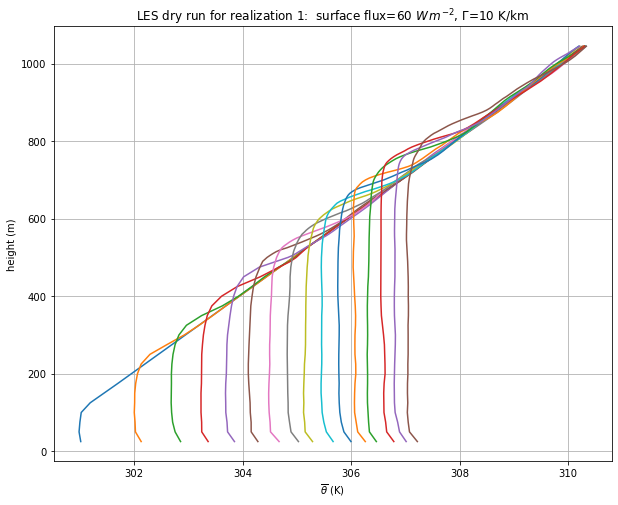

In [6]:
def make_theta(temp,press):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.  #J/kg/K
    cpd=1004.  #J/kg/K
    theta=temp*(p0/press)**(Rd/cpd)
    return theta

case_name='case_60_10.nc'
#
#  look at the first ensemble member
#
ensemble='c1'
with Dataset(case_name,'r') as ncin:
    #
    # grab the group variables
    #
    group = ncin.groups['c1']
    temp=group.variables['TABS'][...]
    press=ncin.variables['press'][...]
    z=ncin.variables['z'][...]
mean_temp=temp.mean(axis=(3,2))

fig,ax=plt.subplots(1,1,figsize=(10,8))
for i in np.arange(0,temp.shape[0],3):
    theta = make_theta(mean_temp[i,:],press)
    ax.plot(theta,z)
out=ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       title='LES dry run for realization 1:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')
ax.grid(True, which='both')

In [7]:
temp.shape

(48, 130, 20, 25)

## Color contour plot of one level for realization c1, last timestep

1. Find the index of the level closest to 400 meters
2. Retrieve the horizontal temperature field for this realization at the last timestep

In [8]:
index=np.searchsorted(z,400.)
temp_400=temp[-1,index,:,:]

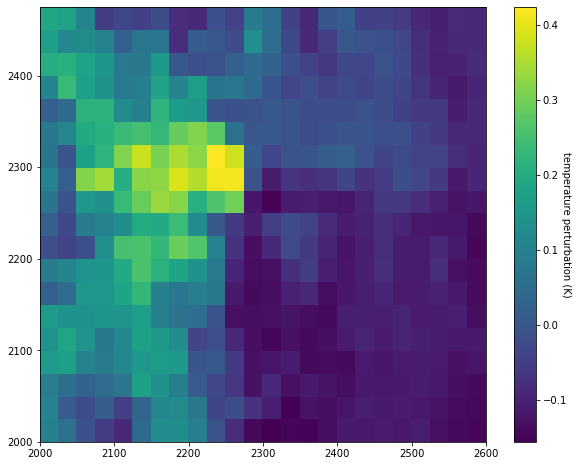

In [9]:
temp_diff=temp_400 - temp_400.mean(axis=(0,1))
fig,ax=plt.subplots(1,1,figsize=(10,8))
with Dataset(case_name,'r') as ncin:
    x=ncin.variables['x'][...]
    y=ncin.variables['y'][...]
cs=ax.pcolormesh(x,y,temp_diff)
cb=fig.colorbar(cs)
cb.set_label('temperature perturbation (K)',rotation=-90)